In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D

\begin{equation}
g(\tilde{\mathbf{w}}_{1},...,\tilde{\mathbf{w}}_{C})=-\sum\limits_{p=1}^{P}
\mbox{log}\frac{e^{\tilde{\mathbf{x}}_{p}^{T}\tilde{\mathbf{w}}_{c_{p}}}}{\sum\limits_{j=1}^{C}e^{\tilde{\mathbf{x}}_{p}^{T}\tilde{\mathbf{w}}_{j}}}
\end{equation}

A small function for calculating the objective value of the function at a given input.

Note: here I'm using a more numerically stable version of the softmax cost, given as 
    
\begin{equation}
 g\left(\tilde{\mathbf{w}}_{1},...,\tilde{\mathbf{w}}_{C}\right)=\underset{p=1}{\overset{P}{\sum}}\mbox{log}\left(\underset{j=1}{\overset{C}{\sum}}e^{\tilde{\mathbf{x}}_{p}^{T}\left(\tilde{\mathbf{w}}_{j}-\tilde{\mathbf{w}}_{c_{p}}\right)}\right)
\end{equation}

where $c_{p}$ is the label index of the $p^{th}$ point.

In [2]:
# calculate the objective value of the softmax multiclass cost for a given input weight W=[w_1,...,w_C]
def calculate_obj(X,y,W):
    # define limits
    P = len(y)
    C = len(np.unique(y))
    
    # loop for cost function
    cost = 0
    for p in range(0,P):
        p_c = int(y[p])-1
        temp = 0
        
        # produce innner sum
        for j in range(0,C):
            temp += np.exp(np.dot(X[:,p].T,(W[:,j] - W[:,p_c])))

        # update outer sum 
        cost+=np.log(temp)
    return cost

We will want to count the number of misclassifications at each epoch of stochastic descent.  To calculate the predicted label value  $\hat{y}_{p}$ of a given point $\mathbf{x}_{p}$ we must compute

\begin{equation}
\hat{y}_{p}=\underset{j=1...C}{\mbox{argmax}}\,\,b_{j}^{\star}+\mathbf{x}_{p}^{T}\mathbf{w}_{j}^{\star}.
\end{equation}

To check whether or not the predicted label $\hat{y}_{p}$ equals the true label value $y_{p}$.  Denoting an indicator function on the two labels  $1_{y_{p},\hat{y}_{p}}=\begin{cases}
1 & \,\mbox{if}\,\,y_{p}\neq\hat{y}_{p}\\
0 & \,\mbox{if}\,\,y_{p}=\hat{y}_{p},
\end{cases}$ then we can count the total number of misclassifications as

\begin{equation}
\textrm{number of misclassifications}=\underset{p=1}{\overset{P}{\sum}}1_{y_{p},\hat{y}_{p}}
\end{equation}

A small snippet of python code for producing this calculation is as follows

In [3]:
# calculate number of misclassifications value for a given input weight W=[w_1,...,w_C]
def calculate_misclass(X,y,W):
    # define limits
    P = len(y)
    
    # loop for cost function
    num_misclass = 0
    for p in range(0,P):
        p_c = int(y[p])-1
        guess = np.argmax(np.dot(X[:,p].T,W))
        if p_c != guess:
            num_misclass+=1
    return num_misclass

Now, we have our stochastic gradient module: we take individual stochastic gradient steps.  The full gradient in just $\tilde{\mathbf{w}}_{c}$ is given as 

\begin{equation}
\nabla_{\mathbf{\tilde{w}}_{c}}g=\underset{p=1}{\overset{P}{\sum}}\left(\frac{1}{\sum_{j=1}^{C}e^{\tilde{\mathbf{x}}_{p}^{T}\left(\tilde{\mathbf{w}}_{j}-\tilde{\mathbf{w}}_{c_{p}}\right)}}-\mathfrak{1}_{c_{p}=c}\right)\mathbf{\tilde{x}}_{p}
\end{equation}

and the gradient in the $p^{th}$ data point is then

\begin{equation}
\left(\frac{1}{\sum_{j=1}^{C}e^{\tilde{\mathbf{x}}_{p}^{T}\left(\tilde{\mathbf{w}}_{j}-\tilde{\mathbf{w}}_{c_{p}}\right)}}-\mathfrak{1}_{c_{p}=c}\right)\mathbf{\tilde{x}}_{p}
\end{equation}

A small function to make this gradient computation is then

In [4]:
# compute cth class gradient for single data point
def compute_grad(x_p,y_p,W,c,C):
    # produce gradient for each class weights
    temp = 0
    for j in range(0,C):
        temp+=np.exp(np.dot(x_p.T,W[:,j] - W[:,c]))
    temp = (np.divide(1,temp) - int(y_p == (c+1)))*x_p
    
    return temp

So during the $k^{th}$ epoch of stochastic gradient in this set of variables we take the gradient descent step in the $p^{th}$ point as

\begin{equation}
\tilde{\mathbf{w}}_{c}^{\left(p\right)}=\tilde{\mathbf{w}}_{c}^{\left(p\right)}-\alpha_{k}\left(\frac{1}{\sum_{j=1}^{C}e^{\tilde{\mathbf{x}}_{p}^{T}\left(\tilde{\mathbf{w}}_{j}-\tilde{\mathbf{w}}_{c_{p}}\right)}}-\mathfrak{1}_{c_{p}=c}\right)\mathbf{\tilde{x}}_{p}
\end{equation}

repeating this for each $p=1...P$.  This we do simultaneously in for all class weights to compute each stochastic gradient step.

A small module for performing these steps in python is given in the next cell.

In [5]:
# learn all C separators together running stochastic gradient descent
def stochastic_softmax_multi(x,y):
    # formulate full input data matrix X
    temp = np.shape(x)  
    temp = np.ones((temp[0],1))
    X = np.concatenate((temp,x),1)
    X = X.T
    
    # initialize variables
    C = len(np.unique(y))
    N,P = np.shape(X)
    W = np.random.randn(N,C)
    
    # record number of misclassifications on training set at each epoch 
    num_misclasses = []
    m = np.random.permutation(P)    # mix up samples

    # outer descent loop
    k = 1
    best_misclass = P      # best number of misclassifications so far
    best_W = W             # best W associated with best classification rate so far
    max_its = 100
    while k <= max_its:
        # set step length
        alpha = 1/math.sqrt(float(k))
        
        # take stochastic step in pth point
        for p in range(0,P):
            # re-initialize full gradient with zeros
            grad = np.zeros((np.shape(W)))
            
            # update each classifier's weights on pth point
            for c in range(0,C):
                # compute cth class gradient in pth point
                x_p = X[:,m[p]]
                y_p = y[m[p]]
                temp = compute_grad(x_p,y_p,W,c,C)
                grad[:,c] = temp.ravel()

            # take stochastic gradient step in all weights
            W = W - alpha*grad

        # update misclass container and associated best W
        current_misclasses = calculate_misclass(X,y,W)
        num_misclasses.append(current_misclasses)
        if current_misclasses <= best_misclass:
            best_misclass = current_misclasses
            best_W = W
        
        # kick up epoch count
        k+= 1
    
    # return goodies
    num_misclasses = np.asarray(num_misclasses)
    num_misclasses.shape = (max_its,1)
    return best_W,num_misclasses

Now that the stage is set, lets run the code on a toy example dataset.

In [7]:
# a toy 2d dataset so we can plot things
data = np.matrix(np.genfromtxt('datasets/3class_data.csv', delimiter=','))
x = np.asarray(data[:,0:2])
y = np.asarray(data[:,2])
y.shape = (np.size(y),1)

Here's what this toy dataset looks like 

In [10]:
# plot toy data
import  /python_files/plotit.py - # from library of plotting functions
plot_toydata(x,y)

ERROR:root:File `u'/python_files/plotit.py'` not found.


NameError: name 'plot_toydata' is not defined

Now, let's run stochastic gradient descent to find separators here

In [10]:
# run /python_files/stochastic 
best_W,num_misclasses = stochastic_softmax_multi(x,y)

We can output the mumber of misclassifications per epoch to make sure things are working well

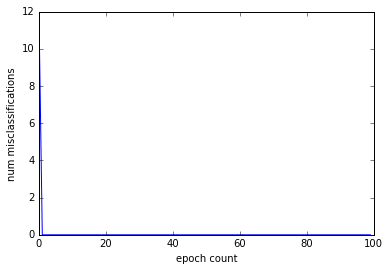

In [11]:
# plot misclassifications at each epoch to make sure everything works properly
plt.plot(num_misclasses)
plt.xlabel('epoch count')
plt.ylabel('num misclassifications')
plt.show()

For the toy dataset we can plot the data as well as the learned separators!

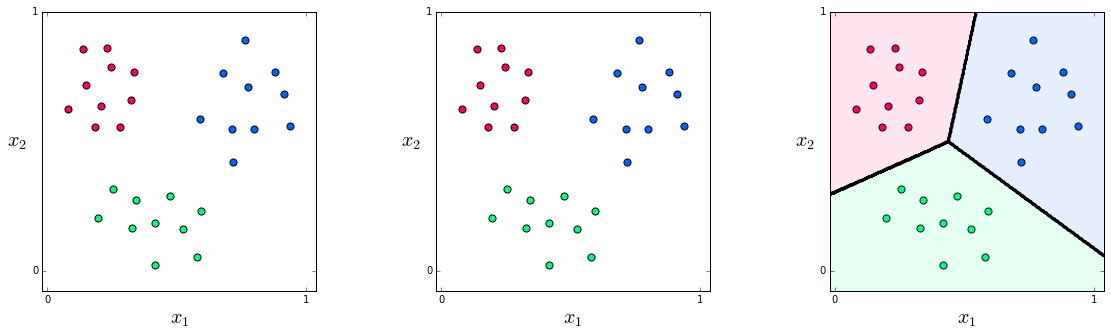

In [12]:
# plot toy data
%run plotit.py - # from library of plotting functions
plot_toydata_wlinear_rules(x,y,best_W)

Then repeat all steps in next few cells with a 4-class dataset just for kicks

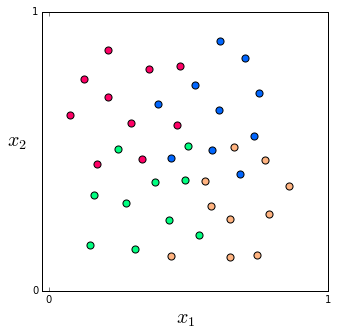

In [16]:
# a toy 2d dataset so we can plot things
data = np.matrix(np.genfromtxt('4class_data.csv', delimiter=','))
x = np.asarray(data[:,0:2])
y = np.asarray(data[:,2])
y.shape = (np.size(y),1)

# plot toy data
%run /python_files/plotit.py - # from library of plotting functions
plot_toydata(x,y)

# run stochastic gradient descent
best_W,num_misclasses = stochastic_softmax_multi(x,y)

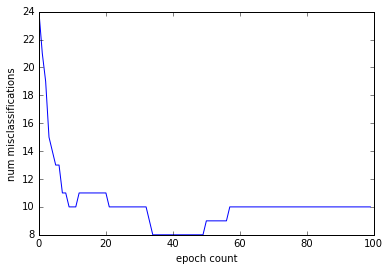

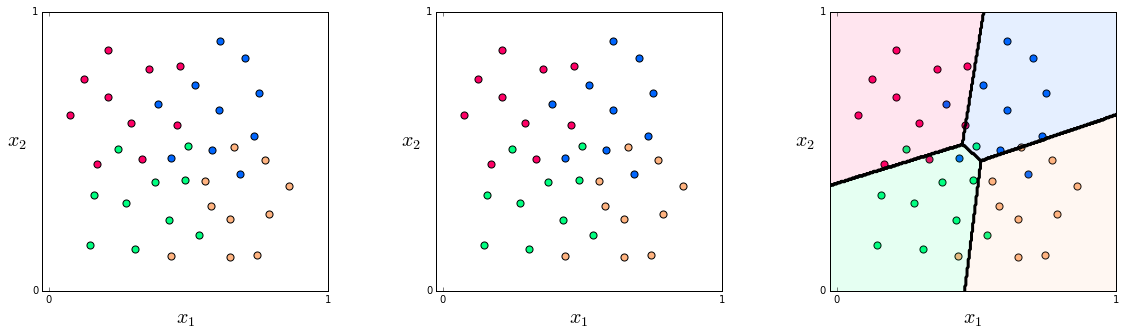

In [17]:
# plot misclassifications at each epoch to make sure everything works properly
plt.plot(num_misclasses)
plt.xlabel('epoch count')
plt.ylabel('num misclassifications')
plt.show()

# plot toy data
%run /python_files/plotit.py - # from library of plotting functions
plot_toydata_wlinear_rules(x,y,best_W)